In [ ]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np
import pickle
import os
import mlflow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool, Legend
from bokeh.io import output_notebook 
output_notebook

: 

Подгружаем очищенную выборку

In [13]:
df = pd.read_pickle('/home/mainuser/LAB2/LR1_IIS/data/clean_car_data.pkl').sample(frac=0.1, random_state = 2) 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 99 to 3
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Car_Name       30 non-null     category
 1   Year           30 non-null     int16   
 2   Selling_Price  30 non-null     float16 
 3   Present_Price  30 non-null     float16 
 4   Driven_kms     30 non-null     int16   
 5   Fuel_Type      30 non-null     object  
 6   Selling_type   30 non-null     category
 7   Transmission   30 non-null     category
 8   Owner          30 non-null     int16   
 9   Fuel_type      30 non-null     category
dtypes: category(4), float16(2), int16(3), object(1)
memory usage: 1.7+ KB


In [14]:
df = df.rename(columns={'Present_Price': 'target'})
df = df.drop(columns=['Year'])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.25, random_state=100)

In [16]:
df

,Car_Name,Selling_Price,target,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner,Fuel_type
99,fortuner,9.648438,20.453125,-15512,Diesel,Dealer,Manual,0,Diesel
161,TVS Apache RTR 180,0.449951,0.826172,23000,Petrol,Individual,Manual,0,Petrol
89,etios g,4.750000,6.761719,-25536,Petrol,Dealer,Manual,0,Petrol
30,ritz,3.099609,5.980469,-14097,Diesel,Dealer,Manual,0,Diesel
232,elantra,11.453125,14.789062,12900,Petrol,Dealer,Automatic,0,Petrol
290,amaze,4.500000,6.398438,19000,Petrol,Dealer,Manual,0,Petrol
35,sx4,2.949219,7.738281,-15538,CNG,Dealer,Manual,0,CNG
7,s cross,6.500000,8.609375,-32107,Diesel,Dealer,Manual,0,Diesel
183,Bajaj Discover 100,0.270020,0.469971,21000,Petrol,Individual,Manual,0,Petrol
13,ertiga,6.101562,7.710938,26000,Petrol,Dealer,Manual,0,Petrol


In [17]:
cat_features = X_train.select_dtypes(include=['category','object']).columns.to_list()
cat_features

['Car_Name', 'Fuel_Type', 'Selling_type', 'Transmission', 'Fuel_type']

In [18]:
num_features = X_train.select_dtypes(include=['number']).columns.to_list()
num_features

['Selling_Price', 'Driven_kms', 'Owner']

In [19]:
s_scaler = StandardScaler()
l_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99999999) 
regressor=RandomForestRegressor()


In [20]:
# Для удобной работы со столбцами
preprocessor = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
    ],
    remainder='drop' ) # Удаляем столбцы, которые не затронуты преобразования

In [21]:

pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Selling_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Fuel_Type',
                                                   'Selling_type',
                                                   'Transmission',
                                                   'Fuel_type'])])),
                ('model', RandomForestRegressor())])

In [22]:
predictions = pipeline.predict(X_test) 

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 1.3100137329101562,
 'mape': 0.8438951789034254,
 'mse': 2.419279423833639}

Работаем с MLflow локально

In [23]:

# Работаем с MLflow локально
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5001

registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)   
mlflow.set_registry_uri(registry_uri)   

In [24]:
# название тестового эксперимента, запуска (run) внутри него, имени, под которым модель будет регистрироваться
EXPERIMENT_NAME = "car_project"
RUN_NAME = "baseline model"
REGISTRY_MODEL_NAME = "car_model_rf"

In [25]:
from mlflow.models import infer_signature

signature =  infer_signature(model_input = X_train.head(5))
input_example = X_train.head(5)
req_file = '../requirements.txt'
params_dict = pipeline.get_params()


/Users/markantimonov/Desktop/LR1_IIS/.my_venv/lib/python3.9/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [ ]:
# experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

In [ ]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/19 02:49:44 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - bokeh (current: 3.4.3, required: bokeh==3.6.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
/Users/markantimonov/Desktop/LR1_IIS/.my_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024/11/19 02:49:45 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - bokeh (current: 3.4.3, required: bokeh==3.6.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install 

In [57]:
mlflow.delete_run('aead09fbc6b6454ea70b5318fc675a2e')

ПУНКТ 10

Лучшие параметры: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 100}


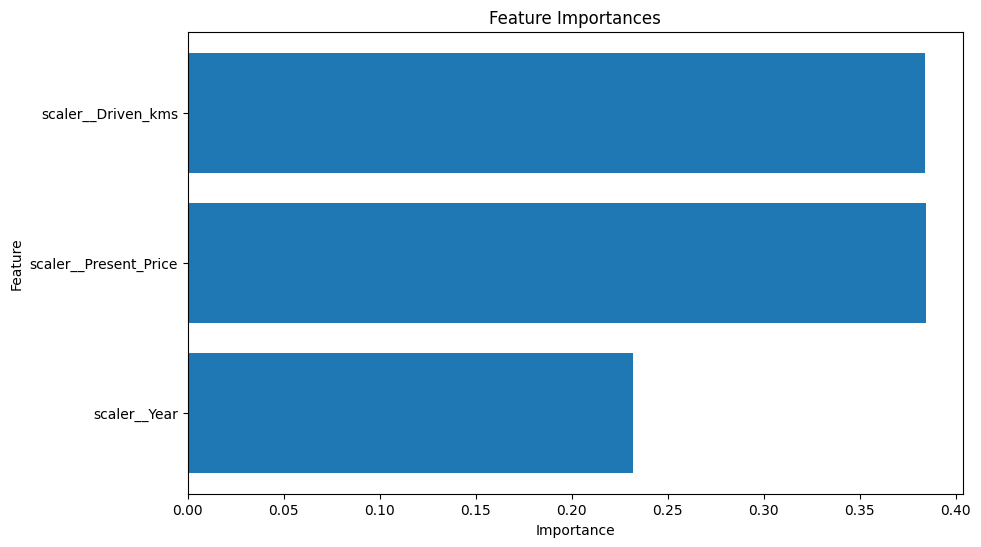

2024/11/19 12:06:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/19 12:06:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run Optimized Model at: http://127.0.0.1:5001/#/experiments/1/runs/5955f8d4e92149a49c02f61763935f56.
2024/11/19 12:06:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1.


Run ID: 5955f8d4e92149a49c02f61763935f56
Оптимизированные метрики: {'mae': 25.052427896433514, 'mape': 2.4241479494546994, 'mse': 856.6091694762122}


In [58]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Подбор гиперпараметров RandomForest
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
}
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Лучшая модель после подбора параметров
best_model = grid_search.best_estimator_
print("Лучшие параметры:", grid_search.best_params_)

# Предсказания и метрики
best_predictions = best_model.predict(X_test)
best_metrics = {
    'mae': mean_absolute_error(y_test, best_predictions),
    'mape': mean_absolute_percentage_error(y_test, best_predictions),
    'mse': mean_squared_error(y_test, best_predictions)
}

# Важность признаков
feature_importances = best_model.named_steps['model'].feature_importances_
feature_names = transformer.get_feature_names_out()

# График важности признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Логирование в MLflow
with mlflow.start_run(experiment_id=experiment_id, run_name="Optimized Model") as run:
    mlflow.sklearn.log_model(best_model, artifact_path="models")
    mlflow.log_metrics(best_metrics)
    print(f"Run ID: {run.info.run_id}")
    print("Оптимизированные метрики:", best_metrics)

ПУНКТ 12

In [59]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import mlflow
import mlflow.sklearn

# Настройка MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5001")
experiment_name = "car_project"
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    raise ValueError(f"Эксперимент с именем '{experiment_name}' не найден.")
else:
    experiment_id = experiment.experiment_id

# Завершение активных запусков
while mlflow.active_run():
    mlflow.end_run()

# Генерация данных
data = pd.DataFrame({
    'Year': np.random.randint(2000, 2023, 500),
    'Present_Price': np.random.uniform(1, 50, 500),
    'Driven_kms': np.random.uniform(500, 100000, 500),
    'target': np.random.uniform(1, 100, 500)
})

# Разделение данных
X = data[['Year', 'Present_Price', 'Driven_kms']]
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование данных
transformer = ColumnTransformer(transformers=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False), ['Present_Price', 'Driven_kms']),
    ('scaler', StandardScaler(), ['Year', 'Present_Price', 'Driven_kms'])
], remainder='passthrough')

X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

# Преобразование в DataFrame
feature_names = transformer.get_feature_names_out()
X_train_fe_sklearn = pd.DataFrame(X_train_transformed, columns=feature_names)

# Sequential Feature Selector
n_features = X_train_fe_sklearn.shape[1]
k_min = max(1, int(n_features * 0.2))
k_max = min(n_features, int(n_features * 0.7))

sfs = SFS(RandomForestRegressor(n_estimators=100, random_state=42),
          k_features=(k_min, k_max),
          forward=True,
          floating=False,
          scoring='neg_mean_squared_error',
          cv=3,
          n_jobs=-1)

# Обучение SFS
sfs = sfs.fit(X_train_fe_sklearn, y_train)

# Выбранные признаки
selected_features = list(sfs.k_feature_names_)
selected_indices = list(sfs.k_feature_idx_)

# Сохранение выбранных признаков
with open("selected_features.txt", "w") as f:
    f.write("\n".join(selected_features))
np.savetxt("selected_indices.txt", selected_indices, fmt='%d')

print("Выбранные признаки:", selected_features)
print("Индексы выбранных признаков:", selected_indices)

# Обновление данных на основе отобранных признаков
X_train_selected = X_train_fe_sklearn.iloc[:, selected_indices]
X_test_selected = pd.DataFrame(X_test_transformed, columns=feature_names).iloc[:, selected_indices]

# Создание пайплайна без SFS
pipeline = Pipeline(steps=[
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Обучение модели на отобранных признаках
pipeline.fit(X_train_selected, y_train)

# Предсказания
predictions = pipeline.predict(X_test_selected)

# Метрики
metrics = {
    'mae': mean_absolute_error(y_test, predictions),
    'mape': mean_absolute_percentage_error(y_test, predictions),
    'mse': mean_squared_error(y_test, predictions)
}

# Логирование в MLflow
RUN_NAME = "Feature Selection with SequentialFeatureSelector"
with mlflow.start_run(experiment_id=experiment_id, run_name=RUN_NAME) as run:
    # Логирование модели
    mlflow.sklearn.log_model(pipeline, artifact_path="models")
    # Логирование метрик
    mlflow.log_metrics(metrics)
    # Логирование выбранных признаков
    mlflow.log_artifact("selected_features.txt")
    mlflow.log_artifact("selected_indices.txt")

    print(f"Run ID: {run.info.run_id}")
    print("Метрики:", metrics)

# Вывод метрик
print("Оценка модели:")
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

Выбранные признаки: ['scaler__Year']
Индексы выбранных признаков: [5]


2024/11/19 12:06:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/19 12:06:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run Feature Selection with SequentialFeatureSelector at: http://127.0.0.1:5001/#/experiments/1/runs/40ac79177965496cacf03df011d21d9d.
2024/11/19 12:06:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1.


Run ID: 40ac79177965496cacf03df011d21d9d
Метрики: {'mae': 23.92822115686647, 'mape': 1.5976822443441259, 'mse': 776.2754196742379}
Оценка модели:
mae: 23.9282
mape: 1.5977
mse: 776.2754


ПУНКТ 14

In [60]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, make_scorer
import optuna
import mlflow
import mlflow.sklearn

# Настройка MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5001")
experiment_name = "car_project"
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    raise ValueError(f"Эксперимент с именем '{experiment_name}' не найден.")
else:
    experiment_id = experiment.experiment_id

# Завершение активных запусков
while mlflow.active_run():
    mlflow.end_run()

# Генерация данных (замените на ваши реальные данные)
data = pd.DataFrame({
    'Year': np.random.randint(2000, 2023, 500),
    'Present_Price': np.random.uniform(1, 50, 500),
    'Driven_kms': np.random.uniform(500, 100000, 500),
    'target': np.random.uniform(1, 100, 500)
})

# Разделение данных
X = data[['Year', 'Present_Price', 'Driven_kms']]
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование данных
transformer = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), ['Year', 'Present_Price', 'Driven_kms'])
], remainder='passthrough')

X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

# Оптимизация гиперпараметров с Optuna
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 5, 20)
    max_features = trial.suggest_float("max_features", 0.1, 1.0)

    # Модель
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        random_state=42
    )

    # Оценка метрики MAE
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    scores = cross_val_score(model, X_train_transformed, y_train, cv=3, scoring=mae_scorer)
    return -scores.mean()  # Optuna минимизирует метрику

# Создание Optuna-исследования
study = optuna.create_study(direction="minimize", study_name="Random Forest Optimization")
study.optimize(objective, n_trials=10)

# Лучшая комбинация гиперпараметров
best_params = study.best_params
print("Лучшие параметры:", best_params)

# Обучение модели с лучшими параметрами
best_model = RandomForestRegressor(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    max_features=best_params["max_features"],
    random_state=42
)
best_model.fit(X_train_transformed, y_train)

# Предсказания
predictions = best_model.predict(X_test_transformed)

# Метрики
metrics = {
    'mae': mean_absolute_error(y_test, predictions),
    'mape': mean_absolute_percentage_error(y_test, predictions),
    'mse': mean_squared_error(y_test, predictions)
}

# Логирование в MLflow
RUN_NAME = "Random Forest with Optuna"
with mlflow.start_run(experiment_id=experiment_id, run_name=RUN_NAME) as run:
    # Логирование модели
    mlflow.sklearn.log_model(best_model, artifact_path="models")
    # Логирование метрик и параметров
    mlflow.log_metrics(metrics)
    mlflow.log_params(best_params)

    print(f"Run ID: {run.info.run_id}")
    print("Метрики:", metrics)

# Регистрация модели
model_uri = f"runs:/{run.info.run_id}/models"
mlflow.register_model(model_uri=model_uri, name="car_modelrf")

# Вывод метрик
print("Оценка модели:")
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

[I 2024-11-19 12:06:56,990] A new study created in memory with name: Random Forest Optimization
[I 2024-11-19 12:06:57,454] Trial 0 finished with value: 26.219366408538615 and parameters: {'n_estimators': 265, 'max_depth': 13, 'max_features': 0.37814956188192106}. Best is trial 0 with value: 26.219366408538615.
[I 2024-11-19 12:06:57,566] Trial 1 finished with value: 25.618239686392258 and parameters: {'n_estimators': 70, 'max_depth': 6, 'max_features': 0.13136381146407808}. Best is trial 1 with value: 25.618239686392258.
[I 2024-11-19 12:06:57,799] Trial 2 finished with value: 26.16243406975725 and parameters: {'n_estimators': 131, 'max_depth': 20, 'max_features': 0.4891382790280948}. Best is trial 1 with value: 25.618239686392258.
[I 2024-11-19 12:06:58,073] Trial 3 finished with value: 26.33810084947902 and parameters: {'n_estimators': 136, 'max_depth': 13, 'max_features': 0.8365951423857656}. Best is trial 1 with value: 25.618239686392258.
[I 2024-11-19 12:06:58,208] Trial 4 finish

Лучшие параметры: {'n_estimators': 70, 'max_depth': 6, 'max_features': 0.13136381146407808}


2024/11/19 12:07:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/19 12:07:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random Forest with Optuna at: http://127.0.0.1:5001/#/experiments/1/runs/5e727b18c2b24b62ab0af40d55061131.
2024/11/19 12:07:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1.
Registered model 'car_modelrf' already exists. Creating a new version of this model...
2024/11/19 12:07:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: car_modelrf, version 3


Run ID: 5e727b18c2b24b62ab0af40d55061131
Метрики: {'mae': 27.27487420161404, 'mape': 2.824024050717826, 'mse': 968.8867010681721}
Оценка модели:
mae: 27.2749
mape: 2.8240
mse: 968.8867


Created version '3' of model 'car_modelrf'.
